# Exploratory Data Analysis - Fraud_Data.csv

This notebook performs exploratory data analysis on the Fraud_Data.csv dataset.

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [8]:
# Load the dataset
fraud_data_path = '../data/raw/Fraud_Data.csv'
fraud_df = pd.read_csv(fraud_data_path)

# Display first few rows
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [9]:
# Basic information about the dataset
print("Shape of the dataset:", fraud_df.shape)
print("\nData types:")
print(fraud_df.dtypes)
print("\nMissing values:")
print(fraud_df.isnull().sum())
print("\nSummary statistics:")
fraud_df.describe()

Shape of the dataset: (151112, 11)

Data types:
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

Missing values:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Summary statistics:


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


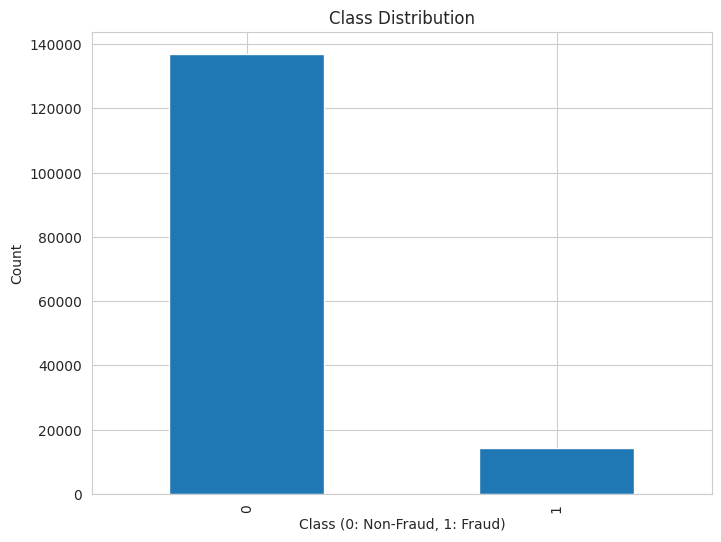

Class distribution:
class
0    136961
1     14151
Name: count, dtype: int64

Percentage:
class
0    90.635423
1     9.364577
Name: proportion, dtype: float64


In [10]:
# Class distribution
plt.figure(figsize=(8, 6))
fraud_df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

print("Class distribution:")
print(fraud_df['class'].value_counts())
print("\nPercentage:")
print(fraud_df['class'].value_counts(normalize=True) * 100)

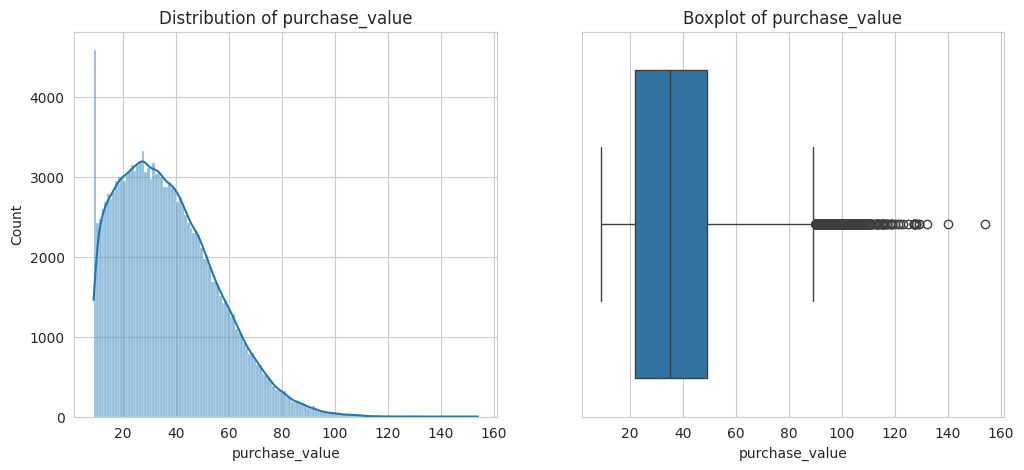

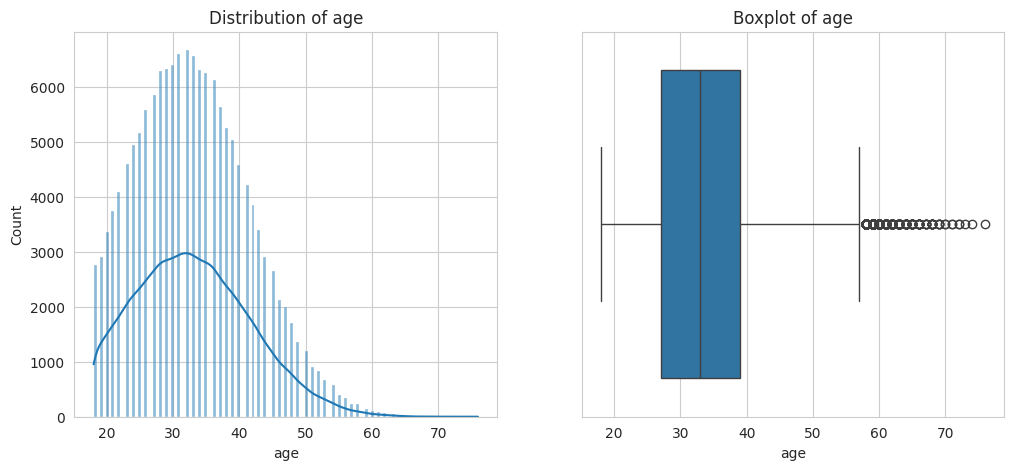

In [11]:
# Univariate analysis - Numerical features
numerical_cols = ['purchase_value', 'age']

for col in numerical_cols:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(fraud_df[col], kde=True)
    plt.title(f'Distribution of {col}')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=fraud_df[col])
    plt.title(f'Boxplot of {col}')
    
    plt.show()

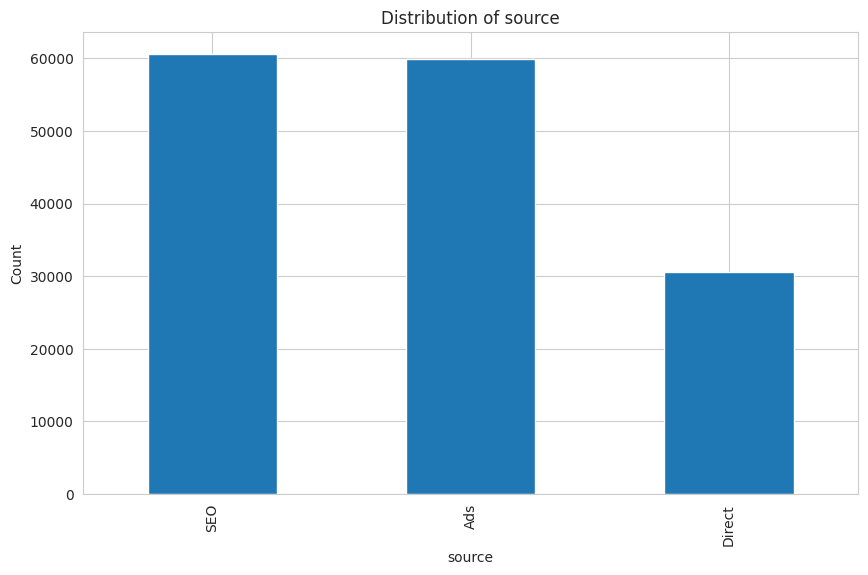

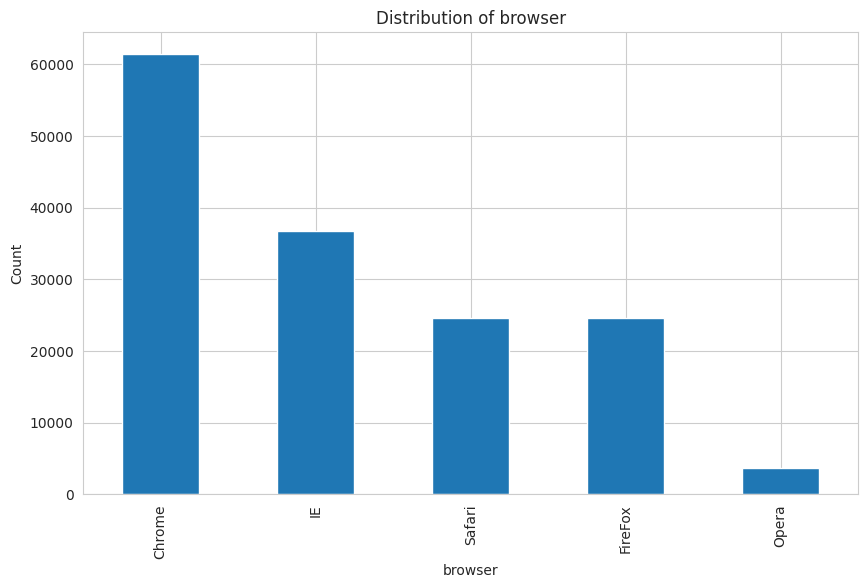

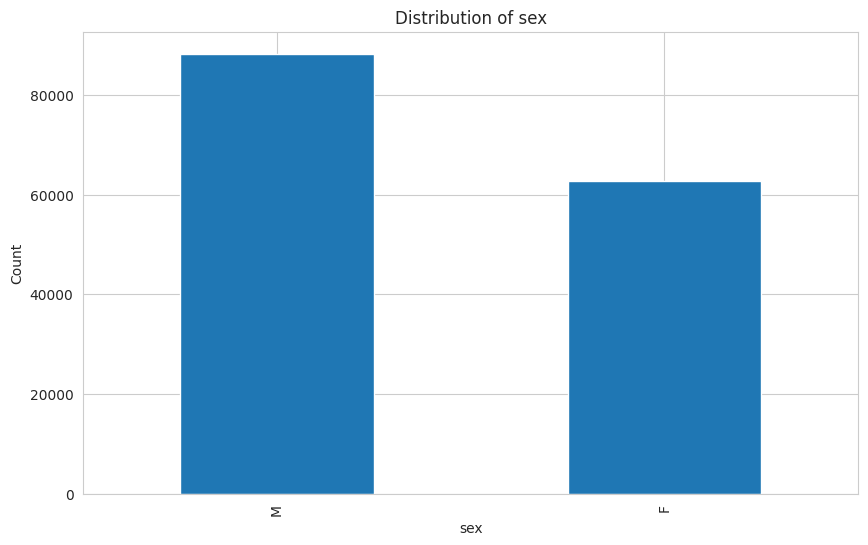

In [12]:
# Univariate analysis - Categorical features
categorical_cols = ['source', 'browser', 'sex']

for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    fraud_df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

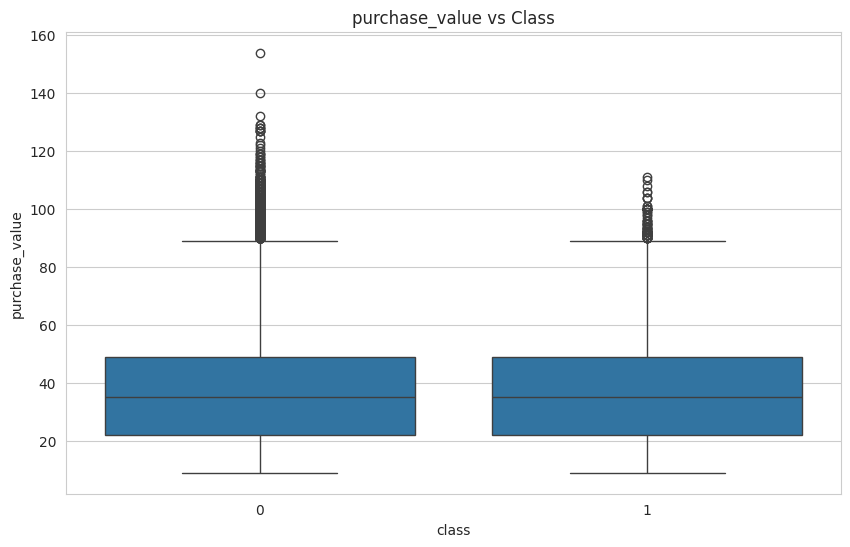

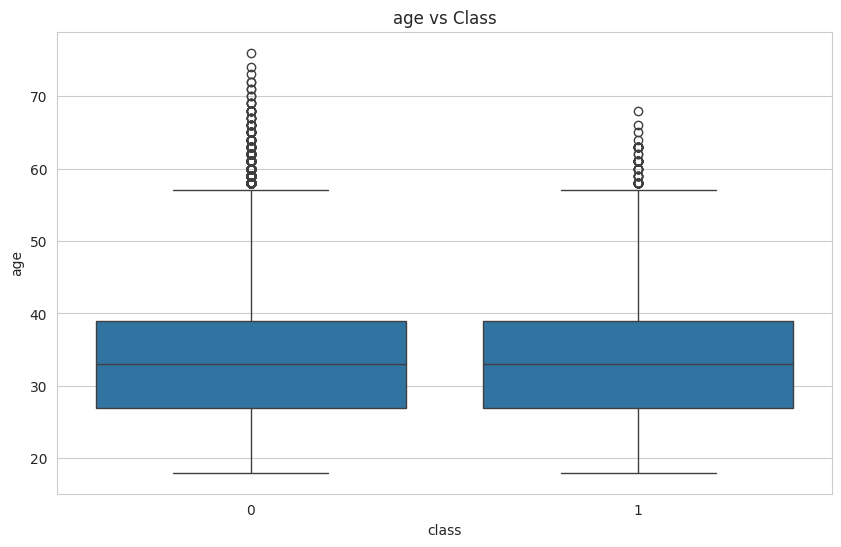

In [13]:
# Bivariate analysis - Numerical features vs Target
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='class', y=col, data=fraud_df)
    plt.title(f'{col} vs Class')
    plt.show()

<Figure size 1000x600 with 0 Axes>

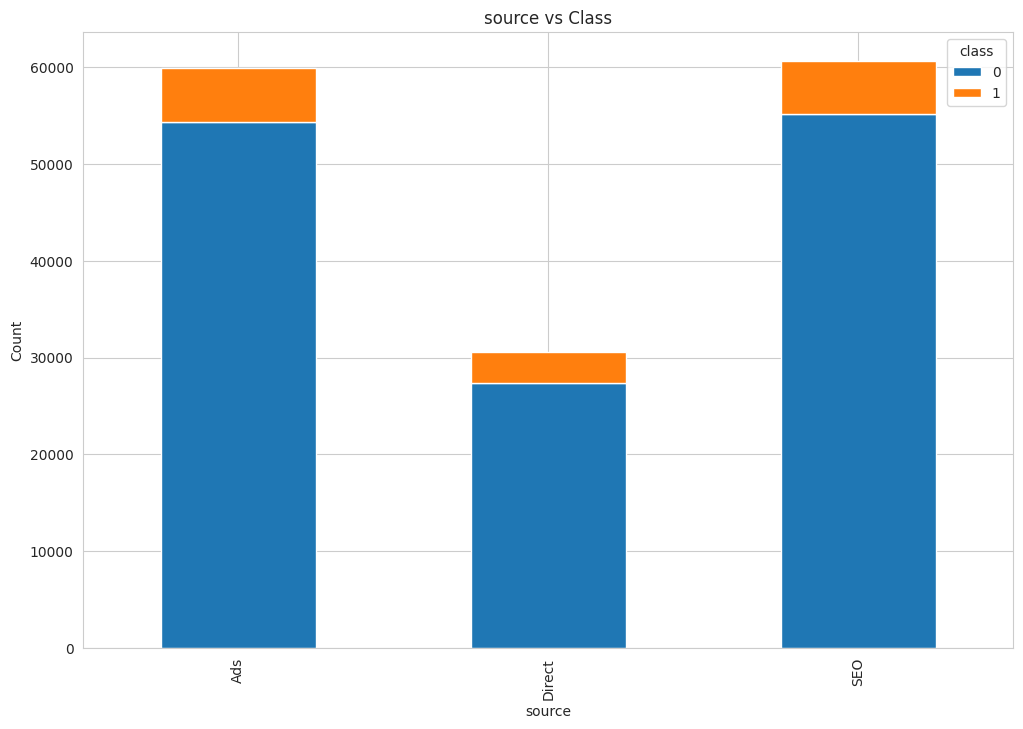

<Figure size 1000x600 with 0 Axes>

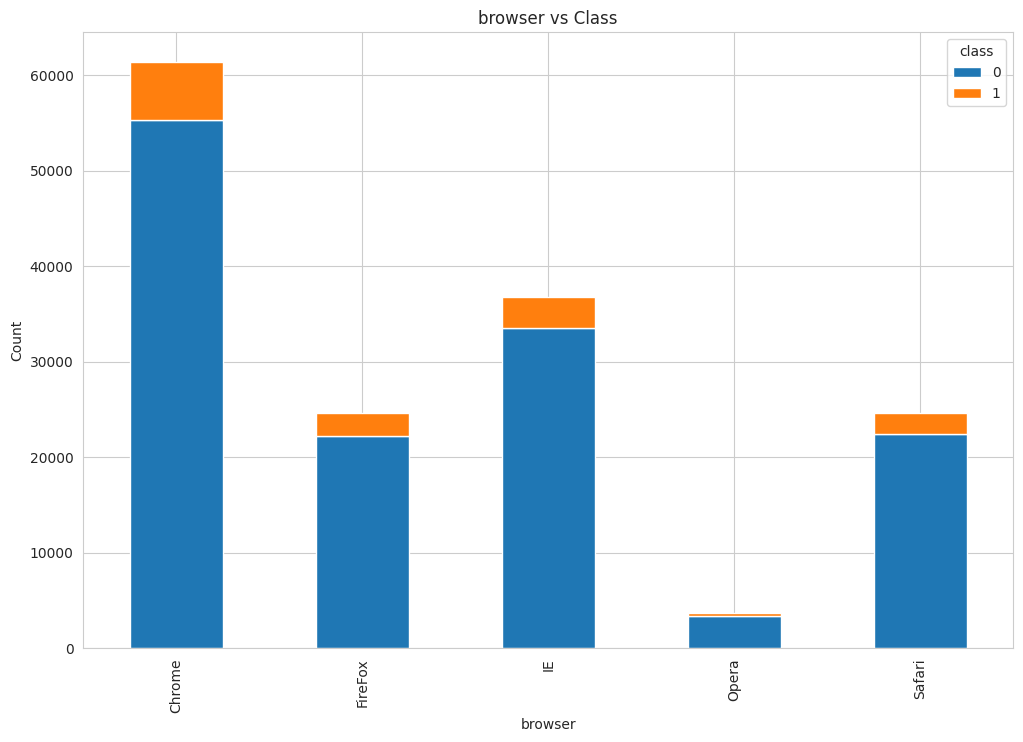

<Figure size 1000x600 with 0 Axes>

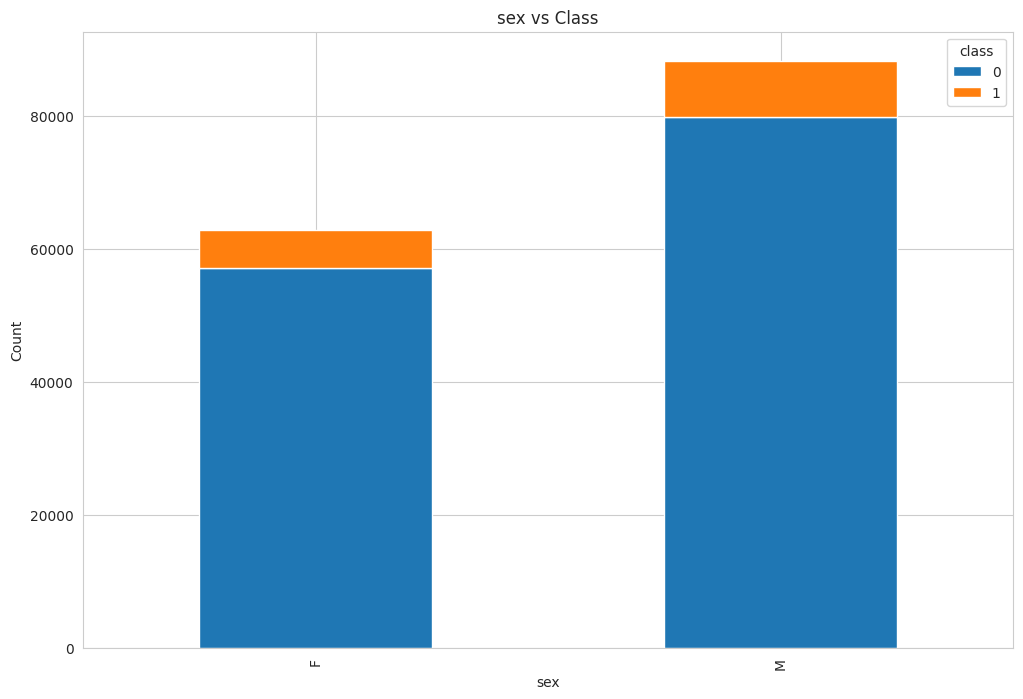

In [14]:
# Bivariate analysis - Categorical features vs Target
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    pd.crosstab(fraud_df[col], fraud_df['class']).plot(kind='bar', stacked=True)
    plt.title(f'{col} vs Class')
    plt.ylabel('Count')
    plt.show()

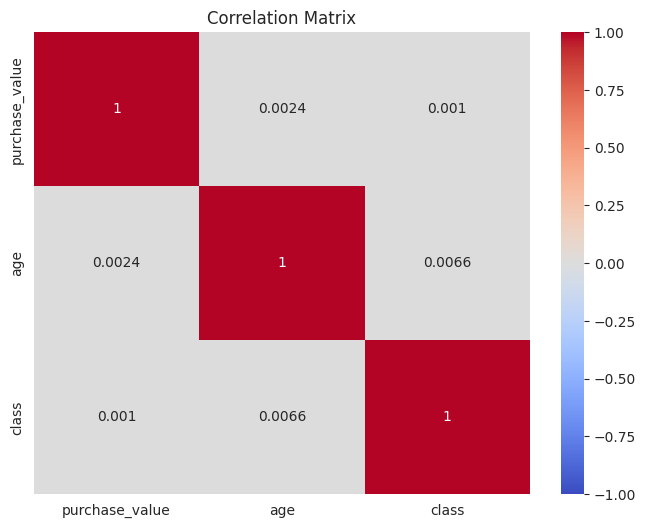

In [15]:
# Correlation heatmap
# Select numerical columns including class
corr_cols = numerical_cols + ['class']
corr_matrix = fraud_df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [16]:
# Convert timestamps to datetime
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

# Extract time-based features
fraud_df['signup_hour'] = fraud_df['signup_time'].dt.hour
fraud_df['signup_day'] = fraud_df['signup_time'].dt.day
fraud_df['signup_month'] = fraud_df['signup_time'].dt.month

fraud_df['purchase_hour'] = fraud_df['purchase_time'].dt.hour
fraud_df['purchase_day'] = fraud_df['purchase_time'].dt.day
fraud_df['purchase_month'] = fraud_df['purchase_time'].dt.month

# Time since signup
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600  # in hours

print("New time-based features added.")

New time-based features added.


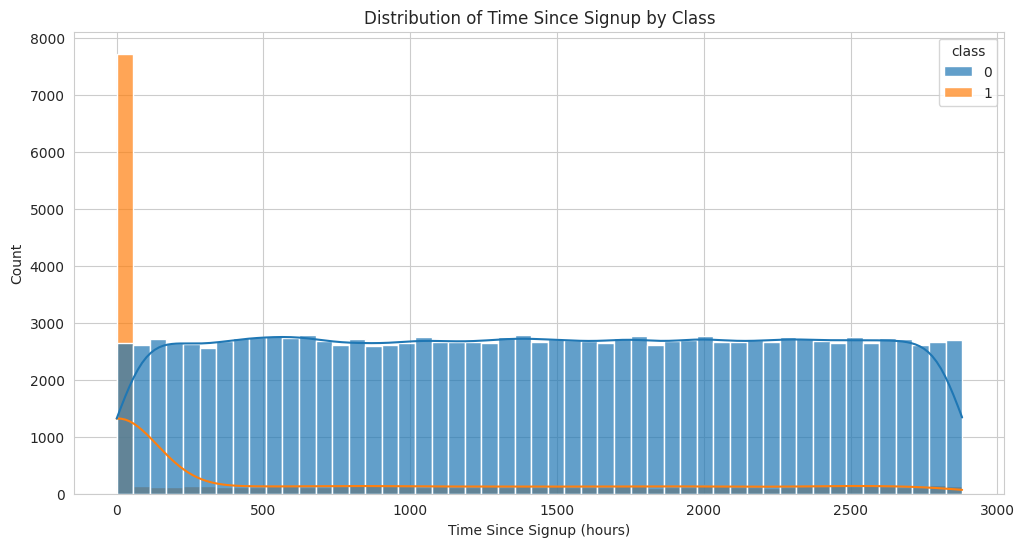

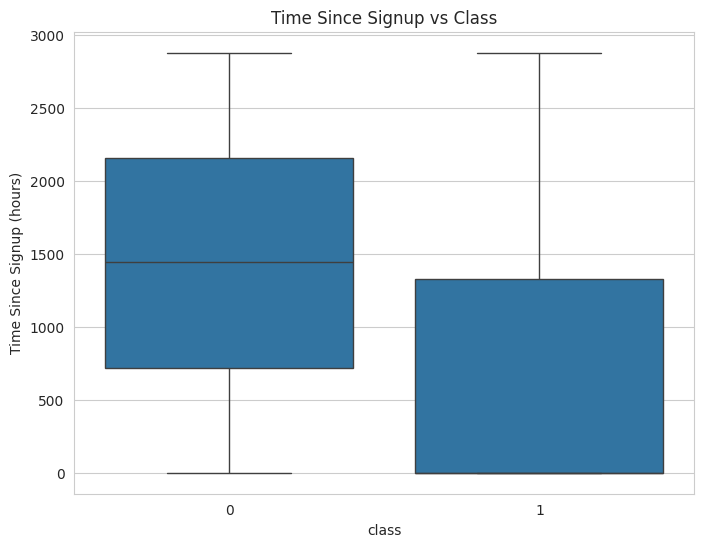

In [17]:
# Analyze time_since_signup
plt.figure(figsize=(12, 6))
sns.histplot(data=fraud_df, x='time_since_signup', hue='class', kde=True, alpha=0.7)
plt.title('Distribution of Time Since Signup by Class')
plt.xlabel('Time Since Signup (hours)')
plt.show()

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='time_since_signup', data=fraud_df)
plt.title('Time Since Signup vs Class')
plt.ylabel('Time Since Signup (hours)')
plt.show()

In [18]:
# Load IP to Country mapping
ip_country_path = '../data/raw/IpAddress_to_Country.csv'
ip_df = pd.read_csv(ip_country_path)

# Convert IP addresses to integers for range lookup
import ipaddress

def ip_to_int(ip):
    try:
        return int(ipaddress.ip_address(ip))
    except:
        return np.nan

fraud_df['ip_address_int'] = fraud_df['ip_address'].apply(ip_to_int)

# Merge with country data
# Note: This is a range-based merge, need to find the country for each IP
def find_country(ip_int):
    if pd.isna(ip_int):
        return 'Unknown'
    matches = ip_df[(ip_df['lower_bound_ip_address'] <= ip_int) & (ip_df['upper_bound_ip_address'] >= ip_int)]
    if not matches.empty:
        return matches['country'].iloc[0]
    return 'Unknown'

fraud_df['country'] = fraud_df['ip_address_int'].apply(find_country)

print("Country mapping completed.")
print("Top 10 countries by transaction count:")
print(fraud_df['country'].value_counts().head(10))

Country mapping completed.
Top 10 countries by transaction count:
country
Unknown    151112
Name: count, dtype: int64


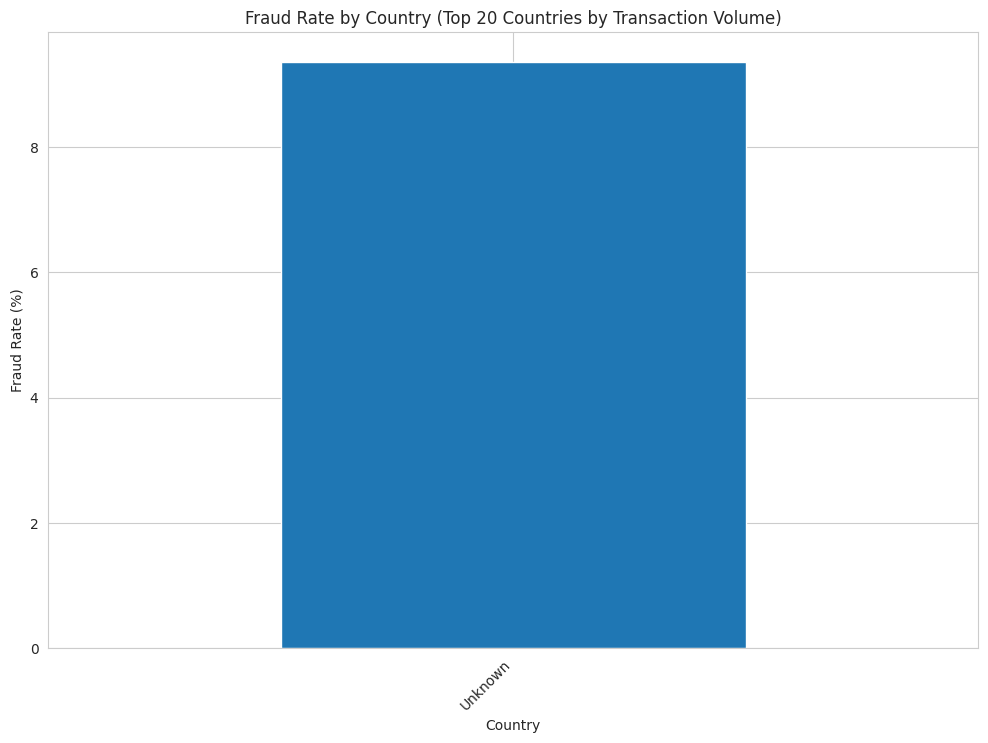

         total_transactions  fraud_transactions  fraud_rate_raw  fraud_rate
country                                                                    
Unknown              151112               14151        0.093646    9.364577


In [19]:
# Analyze fraud patterns by country
country_fraud = fraud_df.groupby('country')['class'].agg(['count', 'sum', 'mean']).sort_values('count', ascending=False).head(20)
country_fraud['fraud_rate'] = country_fraud['mean'] * 100
country_fraud = country_fraud.rename(columns={'count': 'total_transactions', 'sum': 'fraud_transactions', 'mean': 'fraud_rate_raw'})

plt.figure(figsize=(12, 8))
country_fraud['fraud_rate'].plot(kind='bar')
plt.title('Fraud Rate by Country (Top 20 Countries by Transaction Volume)')
plt.xlabel('Country')
plt.ylabel('Fraud Rate (%)')
plt.xticks(rotation=45, ha='right')
plt.show()

print(country_fraud)

In [20]:
# Save the processed data
processed_path = '../data/processed/fraud_data_processed.csv'
fraud_df.to_csv(processed_path, index=False)
print(f"Processed data saved to {processed_path}")

Processed data saved to ../data/processed/fraud_data_processed.csv
